#Ce troisi√®me notebook a pour objectif d‚Äô√©valuer la stabilit√© des segments clients dans le temps, afin de proposer √† KPMG‚Äôs une fr√©quence optimale de mise √† jour du mod√®le de segmentation. √âtant donn√© que le comportement des clients peut √©voluer (nouvelles commandes, changements de r√©gion, variation de profil), il est essentiel de s‚Äôassurer que les segments identifi√©s restent coh√©rents et exploitables sur la dur√©e.
#√Ä partir d‚Äôune simulation bas√©e sur des hypoth√®ses r√©alistes d‚Äô√©volution des donn√©es (ajout de nouveaux clients, changement de fr√©quence d‚Äôachat, etc.), nous analysons l‚Äôimpact de ces perturbations sur la structure des clusters √† l‚Äôaide de m√©triques de similarit√© et de stabilit√© (telles que l‚Äô√©volution du Silhouette Score, du Nombre de clusters actifs, ou encore des taux de reclassification).
#Cette analyse permettra de recommander une fr√©quence de r√©entra√Ænement du mod√®le dans le cadre d‚Äôun futur contrat de maintenance, afin de garantir √† l‚Äô√©quipe Marketing une segmentation toujours fiable et pertinente.

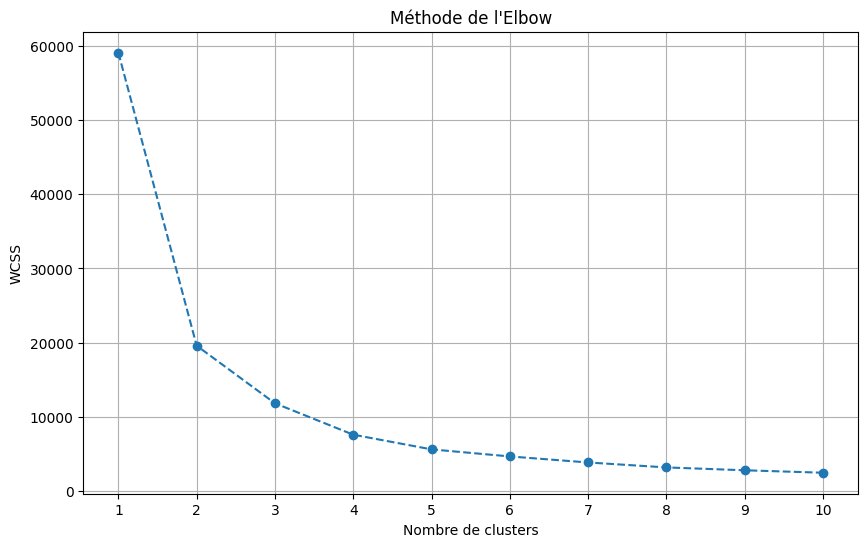

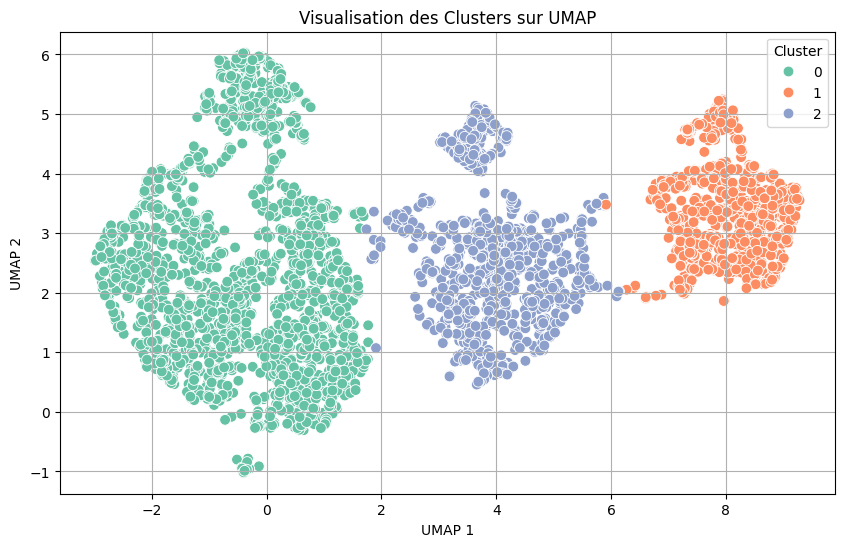

Silhouette Score Initial (K=3) : 0.52

--- Pourcentage de chaque cluster ---
cluster_label
0    53.85
2    24.88
1    21.28
Name: proportion, dtype: float64

--- Interpr√©tation pour 3 clusters ---
- Les clients ont √©t√© segment√©s en 3 groupes √† l‚Äôaide de KMeans sur des donn√©es r√©duites via UMAP.
- Le score de silhouette > 0.30 est souvent consid√©r√© comme un bon seuil pour un clustering raisonnable.
- Les pourcentages permettent d‚Äô√©valuer si un cluster est trop petit ou d√©s√©quilibr√©.
- On peut maintenant suivre cette segmentation dans le temps et tester l‚Äôimpact de l‚Äôarriv√©e de nouveaux clients ou de changements comportementaux.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import umap
def load_and_preprocess_data(excel_file_path, transactions_df=None):
    xls = pd.ExcelFile(excel_file_path)
    customer_demographic = pd.read_excel(xls, sheet_name='CustomerDemographic')
    customer_address = pd.read_excel(xls, sheet_name='CustomerAddress')

    if transactions_df is None:
        transactions = pd.read_excel(xls, sheet_name='Transactions')
    else:
        transactions = transactions_df

    customers = pd.merge(customer_demographic, customer_address, on='customer_id', how='left')

    if not transactions.empty:
        transactions_agg = transactions.groupby('customer_id').agg(
            frequency=('transaction_id', 'count'),
            total_amount=('list_price', 'sum')
        ).reset_index()
    else:
        transactions_agg = pd.DataFrame({'customer_id': [], 'frequency': [], 'total_amount': []})

    customers = pd.merge(customers, transactions_agg, on='customer_id', how='left')

    customers['frequency'] = customers['frequency'].fillna(0)
    customers['total_amount'] = customers['total_amount'].fillna(0)

    customers['gender'] = customers['gender'].replace({'F': 'Female', 'M': 'Male', 'Femal': 'Female', 'U': np.nan})

    customers['DOB'] = pd.to_datetime(customers['DOB'], errors='coerce')
    current_year = pd.to_datetime('today').year
    customers['age'] = current_year - customers['DOB'].dt.year
    customers.loc[customers['age'] > 100, 'age'] = np.nan
    customers.loc[customers['age'] < 18, 'age'] = np.nan

    if 'default' in customers.columns:
        customers = customers.drop(columns=['default'])

    customers = customers.drop(columns=['first_name', 'last_name', 'DOB', 'address'])

    for col in ["age", "property_valuation", "frequency", "total_amount"]:
        if col in customers.columns and customers[col].isnull().any():
            customers[col] = customers[col].fillna(customers[col].median())

    for col in ["gender", "job_title", "job_industry_category", "wealth_segment", "owns_car", "state", "country"]:
        if col in customers.columns and customers[col].isnull().any():
            customers[col] = customers[col].fillna("Missing")

    if not transactions.empty:
        snapshot_date = transactions["transaction_date"].max() + pd.Timedelta(days=1)
        recency_df = transactions.groupby("customer_id").agg(
            last_purchase_date=("transaction_date", "max")
        ).reset_index()
        recency_df["recency"] = (snapshot_date - recency_df["last_purchase_date"]).dt.days
        customers = pd.merge(customers, recency_df[["customer_id", "recency"]], on="customer_id", how="left")
        customers["recency"] = customers["recency"].fillna(customers["recency"].median())
    else:
        customers["recency"] = customers["frequency"].apply(lambda x: 0 if x > 0 else customers["frequency"].median())

    categorical_features = customers.select_dtypes(include='object').columns
    numerical_features = customers.select_dtypes(include=np.number).columns.tolist()
    if 'customer_id' in numerical_features:
        numerical_features.remove('customer_id')

    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ])

    X = preprocessor.fit_transform(customers)

    return customers, X, preprocessor
excel_file_path = 'KPMG_dummy_data.xlsx'
customers_initial, X_initial, preprocessor_initial = load_and_preprocess_data(excel_file_path)

# R√©duction de dimension avec UMAP
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
X_umap = umap_model.fit_transform(X_initial)

# Clustering avec 3 clusters
kmeans_initial = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_initial.fit(X_umap)
customers_initial["cluster_label"] = kmeans_initial.labels_
wcss = []
range_n_clusters = range(1, 11)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_umap)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title("M√©thode de l'Elbow")
plt.xlabel("Nombre de clusters")
plt.ylabel("WCSS")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=customers_initial["cluster_label"], palette="Set2", s=60)
plt.title("Visualisation des Clusters sur UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
silhouette_initial = silhouette_score(X_umap, kmeans_initial.labels_)
print(f"Silhouette Score Initial (K=3) : {silhouette_initial:.2f}")

cluster_percentages = customers_initial["cluster_label"].value_counts(normalize=True) * 100
print("\n--- Pourcentage de chaque cluster ---")
print(cluster_percentages.round(2))
print("\n--- Interpr√©tation pour 3 clusters ---")
print("- Les clients ont √©t√© segment√©s en 3 groupes √† l‚Äôaide de KMeans sur des donn√©es r√©duites via UMAP.")
print("- Le score de silhouette > 0.30 est souvent consid√©r√© comme un bon seuil pour un clustering raisonnable.")
print("- Les pourcentages permettent d‚Äô√©valuer si un cluster est trop petit ou d√©s√©quilibr√©.")
print("- On peut maintenant suivre cette segmentation dans le temps et tester l‚Äôimpact de l‚Äôarriv√©e de nouveaux clients ou de changements comportementaux.")


####Simulation ajout de 100 clients tout en maintenant un UMAP de n_neighbord=8 min_dis=0.0
#### A noter que nous avons fusionn√© certains cellule pour avoir une vue unifi√© du mod√®le apr√®s ajout des 100 clients

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Fonction de chargement et pr√©traitement
def load_and_preprocess_data(excel_file_path, transactions_df=None):
    xls = pd.ExcelFile(excel_file_path)
    customer_demographic = pd.read_excel(xls, sheet_name='CustomerDemographic')
    customer_address = pd.read_excel(xls, sheet_name='CustomerAddress')

    if transactions_df is None:
        transactions = pd.read_excel(xls, sheet_name='Transactions')
    else:
        transactions = transactions_df

    customers = pd.merge(customer_demographic, customer_address, on='customer_id', how='left')

    # Agr√©gation des transactions
    if not transactions.empty:
        transactions_agg = transactions.groupby('customer_id').agg(
            frequency=('transaction_id', 'count'),
            total_amount=('list_price', 'sum')
        ).reset_index()
    else:
        transactions_agg = pd.DataFrame({'customer_id': [], 'frequency': [], 'total_amount': []})

    customers = pd.merge(customers, transactions_agg, on='customer_id', how='left')
    customers['frequency'] = customers['frequency'].fillna(0)
    customers['total_amount'] = customers['total_amount'].fillna(0)

    # Nettoyage et calcul de l‚Äô√¢ge
    customers['gender'] = customers['gender'].replace({'F': 'Female', 'M': 'Male', 'Femal': 'Female', 'U': np.nan})
    customers['DOB'] = pd.to_datetime(customers['DOB'], errors='coerce')
    current_year = pd.to_datetime('today').year
    customers['age'] = current_year - customers['DOB'].dt.year
    customers.loc[customers['age'] > 100, 'age'] = np.nan
    customers.loc[customers['age'] < 18, 'age'] = np.nan

    customers = customers.drop(columns=['first_name', 'last_name', 'DOB', 'address', 'default'], errors='ignore')

    # Imputation des valeurs manquantes
    for col in ["age", "property_valuation", "frequency", "total_amount"]:
        if customers[col].isnull().any():
            customers[col] = customers[col].fillna(customers[col].median())

    for col in ["gender", "job_title", "job_industry_category", "wealth_segment", "owns_car", "state", "country"]:
        customers[col] = customers[col].fillna("Missing")

    # Calcul de la r√©cence
    if not transactions.empty:
        snapshot_date = transactions["transaction_date"].max() + pd.Timedelta(days=1)
        recency_df = transactions.groupby("customer_id").agg(
            last_purchase_date=("transaction_date", "max")
        ).reset_index()
        recency_df["recency"] = (snapshot_date - recency_df["last_purchase_date"]).dt.days
        customers = pd.merge(customers, recency_df[["customer_id", "recency"]], on="customer_id", how="left")
        customers["recency"] = customers["recency"].fillna(customers["recency"].median())
    else:
        customers["recency"] = customers["frequency"].apply(lambda x: 0 if x > 0 else 30)

    # Transformation des donn√©es
    categorical_features = customers.select_dtypes(include='object').columns
    numerical_features = customers.select_dtypes(include=np.number).columns.tolist()
    numerical_features.remove('customer_id')

    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    X = preprocessor.fit_transform(customers)

    return customers, X, preprocessor

# Charger les donn√©es originales
excel_file_path = 'KPMG_dummy_data.xlsx'
customers_initial, X_initial, preprocessor = load_and_preprocess_data(excel_file_path)

# R√©duction de dimension avec UMAP
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
X_umap_initial = umap_model.fit_transform(X_initial)

# Clustering avec KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_umap_initial)
customers_initial['cluster_label'] = kmeans.labels_

# Visualiser la distribution initiale
print("Distribution des clusters initiaux :")
print(customers_initial['cluster_label'].value_counts())
initial_distribution = customers_initial['cluster_label'].value_counts(normalize=True) * 100
print("\nPourcentage par cluster :\n", initial_distribution.round(2))

# ---- SIMULATION DE NOUVEAUX CLIENTS ----
def generate_new_customers(n, existing_customers):
    new_data = []
    for i in range(n):
        sample = existing_customers.sample(1).iloc[0].copy()
        sample['customer_id'] = existing_customers['customer_id'].max() + 1 + i
        sample['frequency'] = np.random.randint(1, 10)
        sample['total_amount'] = np.random.uniform(50, 1000)
        sample['recency'] = np.random.randint(1, 90)
        new_data.append(sample)
    return pd.DataFrame(new_data)

# G√©n√©rer et ajouter 100 clients
new_clients = generate_new_customers(100, customers_initial)
customers_combined = pd.concat([customers_initial.drop(columns='cluster_label'), new_clients], ignore_index=True)

# Charger et concat√©ner les transactions
xls = pd.ExcelFile(excel_file_path)
transactions_old = pd.read_excel(xls, sheet_name='Transactions')

new_transactions = pd.DataFrame({
    'transaction_id': range(900000, 900000 + len(new_clients)),
    'product_id': 999,
    'customer_id': new_clients['customer_id'],
    'transaction_date': pd.to_datetime("today") - pd.to_timedelta(np.random.randint(1, 60, size=len(new_clients)), unit='D'),
    'online_order': True,
    'order_status': 'Approved',
    'brand': 'Generic',
    'product_line': 'Standard',
    'product_class': 'medium',
    'product_size': 'medium',
    'list_price': new_clients['total_amount'] / new_clients['frequency'].replace(0, 1),
    'standard_cost': 100.0
})

transactions_combined = pd.concat([transactions_old, new_transactions], ignore_index=True)

# Recalcul des clusters apr√®s ajout des clients
customers_post_add, X_post_add, _ = load_and_preprocess_data(excel_file_path, transactions_combined)
X_post_add_umap = umap_model.transform(X_post_add)
labels_post_add = kmeans.predict(X_post_add_umap)
customers_post_add['cluster_label'] = labels_post_add

# ---- √âVALUATION DU CHANGEMENT AVEC ARI ----
common_customers = pd.merge(
    customers_initial[['customer_id', 'cluster_label']],
    customers_post_add[['customer_id', 'cluster_label']],
    on='customer_id',
    suffixes=('_initial', '_after')
)

ari = adjusted_rand_score(common_customers['cluster_label_initial'], common_customers['cluster_label_after'])
silhouette_after = silhouette_score(X_post_add_umap, labels_post_add)

print(f"\nSilhouette Score apr√®s ajout de clients : {silhouette_after:.4f}")
print(f"ARI entre clustering initial et apr√®s ajout : {ari:.4f}")

# ---- COMMENTAIRES ARI ----
if ari > 0.85:
    print("üü¢ Clusters tr√®s stables : pas besoin de mise √† jour imm√©diate.")
elif ari > 0.70:
    print("üü† Stabilit√© mod√©r√©e : pr√©voir une v√©rification prochaine.")
else:
    print("üî¥ Attention : clusters instables. Envisager une re-segmentation.")

def check_segmentation_drift(silhouette_score_new, ari_new, cluster_dist_initial, cluster_dist_new, threshold_ari=0.7, threshold_silhouette=0.35, threshold_shift=0.10):
    drift_detected = False
    print("\nüîç V√©rification de d√©rive de segmentation :")

    if silhouette_score_new < threshold_silhouette:
        print(f"‚ö†Ô∏è Silhouette Score faible ({silhouette_score_new:.2f}) < {threshold_silhouette}")
        drift_detected = True
    else:
        print(f"‚úÖ Silhouette Score OK : {silhouette_score_new:.2f}")

    if ari_new < threshold_ari:
        print(f"‚ö†Ô∏è ARI faible ({ari_new:.2f}) < {threshold_ari}")
        drift_detected = True
    else:
        print(f"‚úÖ ARI OK : {ari_new:.2f}")

    cluster_diff = (cluster_dist_initial - cluster_dist_new).abs() / cluster_dist_initial
    if cluster_diff.max() > threshold_shift:
        print(f"‚ö†Ô∏è Changement de r√©partition des clusters d√©tect√© (> {threshold_shift*100:.0f}%)")
        print(cluster_diff)
        drift_detected = True
    else:
        print("‚úÖ R√©partition des clusters stable")

    if drift_detected:
        print("\nüîÅ ‚û§ Re-segmentation recommand√©e.")
    else:
        print("\nüü¢ Segmentation stable. Aucune action n√©cessaire.")

    return drift_detected

drift = check_segmentation_drift(
    silhouette_score_new=silhouette_new_customers,
    ari_new=ari_new_customers,
    cluster_dist_initial=customers_initial["cluster_label"].value_counts(normalize=True),
    cluster_dist_new=customers_evolved_new_customers["cluster_label"].value_counts(normalize=True)
)


Distribution des clusters initiaux :
cluster_label
0    2154
2     994
1     852
Name: count, dtype: int64

Pourcentage par cluster :
 cluster_label
0    53.85
2    24.85
1    21.30
Name: proportion, dtype: float64

Silhouette Score apr√®s ajout de clients : 0.5167
ARI entre clustering initial et apr√®s ajout : 0.9951
üü¢ Clusters tr√®s stables : pas besoin de mise √† jour imm√©diate.

üîç V√©rification de d√©rive de segmentation :
‚ö†Ô∏è Silhouette Score faible (0.10) < 0.35
‚úÖ ARI OK : 1.00
‚ö†Ô∏è Changement de r√©partition des clusters d√©tect√© (> 10%)
cluster_label
0    0.223305
1    0.495305
2    0.059356
Name: proportion, dtype: float64

üîÅ ‚û§ Re-segmentation recommand√©e.


 **R√©sum√© de la strat√©gie de maintenance**
#####Fr√©quence	Action: Mensuel	Calcule Silhouette / ARI / r√©partitions.
##### Si seuil d√©pass√©	Re-clusterise, refais l‚Äôanalyse avec m√©thode du coude + stabilit√©.
on peut mettre en place un syst√®me de suivi qui va mettre √† jour le mod√®le si les seuils critiques sont atteints.